In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from sklearn.metrics import mean_squared_error

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
df = yf.download('GOOG', start='2010-01-01', end='2024-09-01')

data = df[['Close']].values

[*********************100%***********************]  1 of 1 completed


In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)


In [ ]:
train_size = int(len(scaled_data) * 0.8)
val_size = int(len(scaled_data) * 0.10)
test_size = len(scaled_data) - train_size - val_size

train_data = scaled_data[:train_size]
val_data = scaled_data[train_size:train_size + val_size]
test_data = scaled_data[train_size + val_size:]
print("Train data shape:", train_data.shape)
print("Validation data shape:", val_data.shape)
print("Test data shape:", test_data.shape)


Train data shape: (2952, 1)
Validation data shape: (369, 1)
Test data shape: (369, 1)


In [ ]:
def create_dataset(data, time_step=60):
    X, Y = [], []
    for i in range(time_step, len(data)):
        X.append(data[i-time_step:i, 0])
        Y.append(data[i, 0])
    return np.array(X), np.array(Y)

In [ ]:
time_step = 60
X_train, y_train = create_dataset(train_data, time_step)
X_val, y_val = create_dataset(val_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

X_train = torch.tensor(X_train, dtype=torch.float32).unsqueeze(2)
y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_val = torch.tensor(X_val, dtype=torch.float32).unsqueeze(2)
y_val = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)
X_test = torch.tensor(X_test, dtype=torch.float32).unsqueeze(2)
y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)
X_train = X_train.to(device)
y_train = y_train.to(device)
X_val = X_val.to(device)
y_val = y_val.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1, dropout_prob=0.1):
        super(LSTMModel, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size, batch_first=True)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(hidden_layer_size, output_size)

    def forward(self, x):
        h_0 = torch.zeros(1, x.size(0), self.hidden_layer_size).to(x.device)
        c_0 = torch.zeros(1, x.size(0), self.hidden_layer_size).to(x.device)
        out, _ = self.lstm(x, (h_0, c_0))
        out = self.dropout(out[:, -1, :])
        out = self.fc(out)
        return out


In [ ]:
model = LSTMModel().to(device)


criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
epochs = 300
train_losses = []
val_losses = []
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    y_train_pred = model(X_train.to(device))
    loss = criterion(y_train_pred, y_train)
    loss.backward()
    optimizer.step()

    with torch.no_grad():
        val_pred = model(X_val.to(device))
        val_loss = criterion(val_pred, y_val)

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {loss.item()}, Val Loss: {val_loss.item()}")
    train_losses.append(loss.item())
    val_losses.append(val_loss.item())

Epoch 1/300, Train Loss: 0.05723520368337631, Val Loss: 0.3220764994621277
Epoch 2/300, Train Loss: 0.05038199573755264, Val Loss: 0.29846736788749695
Epoch 3/300, Train Loss: 0.04442569240927696, Val Loss: 0.2749793827533722
Epoch 4/300, Train Loss: 0.03898794203996658, Val Loss: 0.25363868474960327
Epoch 5/300, Train Loss: 0.03405690938234329, Val Loss: 0.22920380532741547
Epoch 6/300, Train Loss: 0.030040262266993523, Val Loss: 0.2063293606042862
Epoch 7/300, Train Loss: 0.026594804599881172, Val Loss: 0.18413227796554565
Epoch 8/300, Train Loss: 0.024058697745203972, Val Loss: 0.16050513088703156
Epoch 9/300, Train Loss: 0.022690678015351295, Val Loss: 0.1383652538061142
Epoch 10/300, Train Loss: 0.02245708554983139, Val Loss: 0.1188255250453949
Epoch 11/300, Train Loss: 0.023207951337099075, Val Loss: 0.10373715311288834
Epoch 12/300, Train Loss: 0.024108219891786575, Val Loss: 0.09837096929550171
Epoch 13/300, Train Loss: 0.024584678933024406, Val Loss: 0.09578575193881989
Epoch 

In [ ]:
model.eval()
with torch.no_grad():
    train_pred = model(X_train.to(device))
    test_pred = model(X_test.to(device))

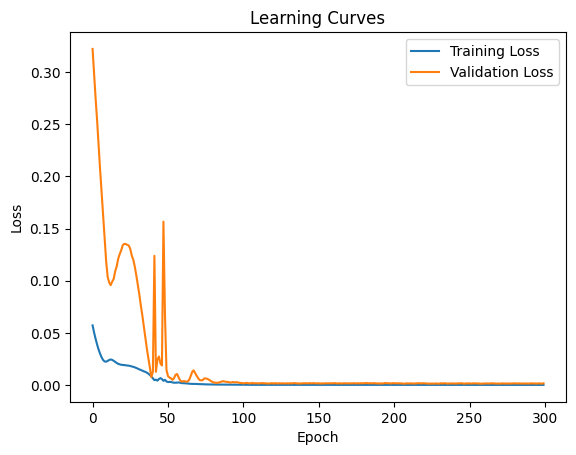

In [ ]:
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curves')
plt.legend()
plt.show()

Train RMSE: 1.4325776100158691, Test RMSE: 4.374875545501709
Train Accuracy: 97.57807236164808%, Test Accuracy: 97.69041258841753%


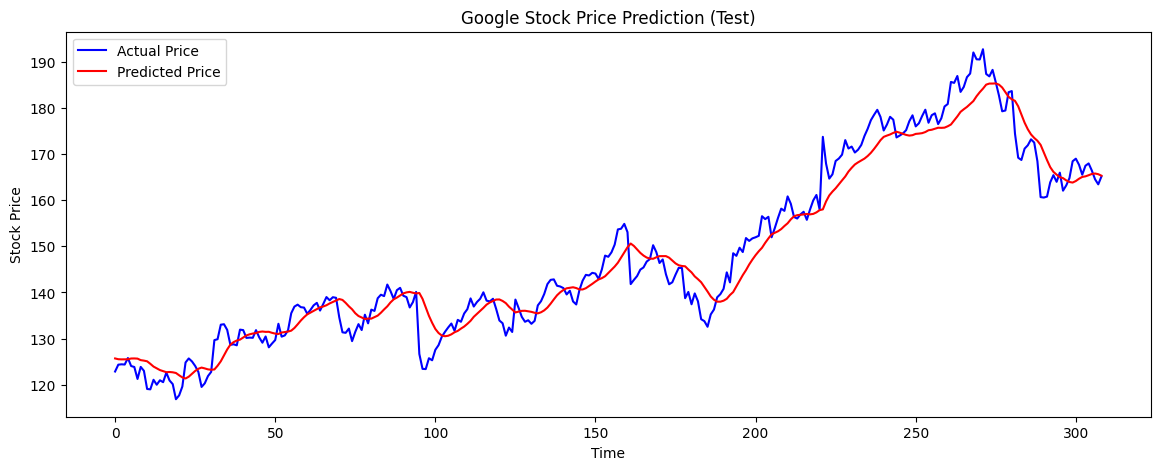

In [ ]:
train_pred = scaler.inverse_transform(train_pred.cpu().numpy())
test_pred = scaler.inverse_transform(test_pred.cpu().numpy())
y_train = scaler.inverse_transform(y_train.cpu().numpy())
y_test = scaler.inverse_transform(y_test.cpu().numpy())

train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))

def calculate_accuracy(y_true, y_pred):
    return 100 - np.mean(np.abs((y_true - y_pred) / y_true)) * 100

train_accuracy = calculate_accuracy(y_train, train_pred)
test_accuracy = calculate_accuracy(y_test, test_pred)

print(f'Train RMSE: {train_rmse}, Test RMSE: {test_rmse}')
print(f'Train Accuracy: {train_accuracy}%, Test Accuracy: {test_accuracy}%')

plt.figure(figsize=(14, 5))
plt.plot(y_test, label='Actual Price', color='blue')
plt.plot(test_pred, label='Predicted Price', color='red')
plt.title('Google Stock Price Prediction (Test)')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [ ]:
input_date = input("Enter the date in YYYY-MM-DD format (e.g., 2024-01-01): ")
df = yf.download('GOOG', start='2010-01-01', end=input_date)
data = df[['Close']].values
scaled_data = scaler.transform(data)


last_60_days = scaled_data[-60:]

input_data = torch.tensor(last_60_days, dtype=torch.float32).unsqueeze(0).unsqueeze(2).to(device)

input_data = input_data.squeeze(3)

model.eval()
with torch.no_grad():
     prediction = model(input_data)

predicted_price = scaler.inverse_transform(prediction.cpu().numpy())
print(f"Predicted closing price for {input_date}: {predicted_price[0][0]}")
actual_price = df['Close'][-1]

print(f"Actual closing price for {input_date}: {actual_price}")

Enter the date in YYYY-MM-DD format (e.g., 2024-01-01): 2017-08-08


[*********************100%***********************]  1 of 1 completed

Predicted closing price for 2017-08-08: 47.14078903198242
Actual closing price for 2017-08-08: 46.46799850463867



<ipython-input-57-d6df7d7cd398>:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  actual_price = df['Close'][-1]


In [ ]:
pip install torch.onnx


In [ ]:
import os
import torch
import torch.onnx
from google.colab import files

current_dir = os.getcwd()
model_save_path = os.path.join(current_dir, 'models', 'model.onnx')

if not os.path.exists(os.path.dirname(model_save_path)):
    os.makedirs(os.path.dirname(model_save_path))

dummy_input = torch.randn(1, 60, 1).to(device)

torch.onnx.export(
    model,                            # The model to be exported
    dummy_input,                      # Dummy input for tracing
    model_save_path,                  # File path where the ONNX model will be saved
    export_params=True,               # Store the trained parameter weights
    opset_version=11,                 # ONNX version (11 is widely compatible)
    input_names=['input'],            # Name for the model's input
    output_names=['output'],          # Name for the model's output
    dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}}  # Allow variable batch sizes
)


print(f'Model saved to {os.path.abspath(model_save_path)}')

files.download(model_save_path)


Model saved to /content/models/model.onnx


/usr/local/lib/python3.10/dist-packages/torch/onnx/symbolic_opset9.py:4545: UserWarning: Exporting a model to ONNX with a batch_size other than 1, with a variable length with LSTM can cause an error when running the ONNX model with a different batch size. Make sure to save the model with a batch size of 1, or define the initial states (h0/c0) as inputs of the model. 
  warnings.warn(


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

https://colab.research.google.com/drive/1h-k7tYz3rnY2kCE7-4CI6OshZKVKNGzJ